### Imports

In [16]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/23m1508/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/23m1508/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [39]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/23m1508/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [42]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/23m1508/nltk_data...


True

In [46]:
from nltk.corpus import movie_reviews as reviews
from sklearn.datasets import fetch_20newsgroups
from gensim.models import KeyedVectors
from gensim.models import word2vec

# import wget
import numpy as np
import pandas as pd
import re
import datetime
from operator import itemgetter
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt

import os
import time
import string
import dill
import pickle
import gzip

from nltk import *
from nltk import wordpunct_tokenize, WordNetLemmatizer, sent_tokenize, pos_tag
from nltk.corpus import stopwords as sw, wordnet as wn
from nltk.stem.snowball import SnowballStemmer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, classification_report as clsr
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split as tts
from sklearn.manifold import TSNE
from sklearn.multiclass import OneVsRestClassifier

import tensorflow as tf


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json


from tensorflow.keras.layers import BatchNormalization, Embedding, Dense, LSTM, SpatialDropout1D, Activation, Conv1D, MaxPooling1D, Input, concatenate
from tensorflow.keras.utils import to_categorical

### Data retrieving

In [47]:
# Load from .csv file with complete dataset
data_essays = pd.read_csv('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/essays.csv', encoding = "ISO-8859-1")
data_essays['cEXT'] = np.where(data_essays['cEXT']=='y', 1, 0)
data_essays['cNEU'] = np.where(data_essays['cNEU']=='y', 1, 0)
data_essays['cAGR'] = np.where(data_essays['cAGR']=='y', 1, 0)
data_essays['cCON'] = np.where(data_essays['cCON']=='y', 1, 0)
data_essays['cOPN'] = np.where(data_essays['cOPN']=='y', 1, 0)
X_essays = data_essays['TEXT'].tolist()
y_essays = data_essays[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']]
data_essays['text length'] = data_essays['TEXT'].apply(len)
labels = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']
X_train, X_test, y_train, y_test = tts(X_essays, y_essays, test_size=0.2)

In [48]:
y_train

,cEXT,cNEU,cAGR,cCON,cOPN
309,1,1,0,0,0
2392,0,0,1,0,1
342,0,0,0,1,0
521,0,0,1,1,0
1343,0,0,1,1,1
...,...,...,...,...,...
505,0,1,1,1,1
1743,0,1,0,1,0
2012,1,0,1,0,1
1987,1,0,0,0,1


In [49]:
len(X_train)

1973

In [50]:
# Train-test split to save the dataset
with open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [51]:
# Load train and test sets from pickled lists
with open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/X_train.pkl', 'rb') as pickle_file:
    X_train = pickle.load(pickle_file)
with open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/X_test.pkl', 'rb') as pickle_file:
    X_test = pickle.load(pickle_file)
with open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/y_train.pkl', 'rb') as pickle_file:
    y_train = pickle.load(pickle_file)
with open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/y_test.pkl', 'rb') as pickle_file:
    y_test = pickle.load(pickle_file)

### Visualization

In [52]:
import random
class visualize:

    def __init__(self, complete_dataset, X, labels_list):
        self.data = complete_dataset
        self.X = X
        self.labels_list = labels_list

    def textlength_vs_labels_histogram(self):
        # Visualization of histograms of text length vs. label
        for label in self.labels_list:
            g = sns.FacetGrid(data=self.data, col=label)
            g.map(plt.hist, 'text length', bins=50)
        plt.show()

    def textlength_vs_labels_boxplot(self):
        # Visualization of boxplots of text length vs. label
        for i, label in enumerate(self.labels_list):
            plt.figure(i)
            sns.boxplot(x=label, y='text length', data=self.data)
        plt.show()

    def most_frequent_words(self):
        # Visualization of the most frequent words
        complete_corpus = ' '.join(self.X)
        words = tokenize.word_tokenize(complete_corpus)
        fdist = FreqDist(words)
        print("List of 100 most frequent words/counts")
        print(fdist.most_common(100))
        fdist.plot(40)

    def most_frequent_words_preprocessed(self):
        # Visualization of the most frequent words
        if not hasattr(self, 'X_preprocess'):
            preprocessor = train(corpus = self.X).NLTKPreprocessor
            self.X_preprocess = prep.transform(self.X).tolist()
        complete_corpus = ' '.join(self.X_preprocess)
        words = tokenize.word_tokenize(complete_corpus)
        fdist = FreqDist(words)
        print("List of 100 most frequent words/counts")
        print(fdist.most_common(100))
        fdist.plot(40)

    def get_corpus_statistics(self):
        # Retrieve some info on the text data
        numWords = []
        for text in self.X:
                counter = len(text.split())
                numWords.append(counter)  
        numFiles = len(numWords)
        print('The total number of essays is', numFiles)
        print('The total number of words in all essays is', sum(numWords))
        print('The average number of words in each essay is', sum(numWords)/len(numWords))

    def get_preprocessed_corpus_statistics(self):
        # Retrieve some info on the preprocessed text data
        if not hasattr(self, 'X_preprocess'):
            preprocessor = train(corpus = self.X).NLTKPreprocessor
            self.X_preprocess = prep.transform(self.X).tolist()
        len_list = [np.count_nonzero(self.X_preprocess[i]) for i in range(len(self.X))]
        print('The average number of words in each preprocessed essay is', np.mean(len_list))
        print('The standard deviation of the number of words in each preprocessed essay is', np.std(len_list))
        print('The average number of words in each preprocessed essay plus 2 standard deviations is', np.mean(len_list) + 2 * np.std(len_list))

class tsne:
    
    def __init__(self, X, max_features = 30000, max_sentence_len = 300, embed_dim = 300,  n_elements = 100):
        self.X = X
        self.max_features =max_features
        self.max_sentence_len = max_sentence_len
        self.embed_dim = embed_dim
        self.n_elements = n_elements
        self.vectors, self.words, self.dic =  self.prepare_embedding(self.X)

    def load_google_vec(self):

        return KeyedVectors.load_word2vec_format(
            '/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/GoogleNews-vectors-negative300.bin',
            binary=True)

    def lemmatize_token(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)
        return WordNetLemmatizer().lemmatize(token, tag)


    def get_preprocessed_corpus(self, X_corpus):
        """
        Returns a preprocessed version of a full corpus (ie. tokenization and lemmatization using POS taggs)
        """
        X = ' '.join(X_corpus)
        lemmatized_tokens = []

        # Break the document into sentences
        for sent in sent_tokenize(X):

            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):

                # Apply preprocessing to the token
                token = token.lower()
                token = token.strip()
                token = token.strip('_')
                token = token.strip('*')

                # If punctuation or stopword, ignore token and continue
                if token in set(sw.words('english')) or all(char in set(string.punctuation) for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize_token(token, tag)
                lemmatized_tokens.append(lemma)

        doc = ' '.join(lemmatized_tokens)
        return doc


    def prepare_embedding(self, X):
        """
        Returns the embedding weights matrix, the word index, and the word-vector dictionnary corresponding
        to the training corpus set of words.
        """
        # Load Word2Vec vectors
        word2vec = self.load_google_vec()

        # Fit and apply an NLTK tokenizer on the preprocessed training corpus to obtain sequences.
        tokenizer = Tokenizer(num_words=self.max_features)
        X_pad = self.get_preprocessed_corpus(X)
        tokenizer.fit_on_texts(pd.Series(X_pad))
        X_pad = tokenizer.texts_to_sequences(pd.Series(X_pad))

        # Pad the sequences
        X_pad = pad_sequences(X_pad, maxlen=self.max_sentence_len, padding='post', truncating='post')

        # Retrieve the word index
        train_word_index = tokenizer.word_index

        # Construct the embedding weights matrix and word-vector dictionnary
        train_embedding_weights = np.zeros((len(train_word_index) + 1, self.embed_dim))
        for word, index in train_word_index.items():
            train_embedding_weights[index, :] = word2vec[word] if word in word2vec else np.random.rand(self.embed_dim)
        word_vector_dict = dict(zip(pd.Series(list(train_word_index.keys())),
                                    pd.Series(list(train_word_index.keys())).apply(
                                        lambda x: train_embedding_weights[train_word_index[x]])))
        return train_embedding_weights, train_word_index, word_vector_dict


    def plot(self):
        labels = []
        tokens = []

        l_bound = 0
        u_bound = len(self.words)
        step = int(len(self.words)/self.n_elements)

        #for index in range(l_bound,u_bound, step):
        for index in random.sample(range(l_bound,u_bound), self.n_elements):
            tokens.append(self.vectors[index])
            labels.append(self.words[index])

        tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
        new_values = tsne_model.fit_transform(tokens)

        xx = []
        yy = []
        for value in new_values:
            xx.append(value[0])
            yy.append(value[1])

        plt.figure(figsize=(16, 16))
        for i in range(len(xx)):
            plt.scatter(xx[i],yy[i])
            plt.annotate(labels[i],
                         xy=(xx[i], yy[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
        plt.show()

In [85]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import tokenize, pos_tag, FreqDist, sent_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords as sw, wordnet as wn
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors  # For loading Word2Vec vectors

# Visualization class for dataset analysis
class visualize:

    def __init__(self, complete_dataset, X, labels_list):
        self.data = complete_dataset  # Complete dataset with text and labels
        self.X = X  # List of text data
        self.labels_list = labels_list  # List of labels corresponding to the text data

    def textlength_vs_labels_histogram(self):
        # Visualization of histograms of text length vs. label
        for label in self.labels_list:
            g = sns.FacetGrid(data=self.data, col=label)
            g.map(plt.hist, 'text length', bins=50)
        plt.show()

    def textlength_vs_labels_boxplot(self):
        # Visualization of boxplots of text length vs. label
        for i, label in enumerate(self.labels_list):
            plt.figure(i)
            sns.boxplot(x=label, y='text length', data=self.data)
        plt.show()

    def most_frequent_words(self):
        # Visualization of the most frequent words in the dataset
        complete_corpus = ' '.join(self.X)  # Combine all text into a single string
        words = tokenize.word_tokenize(complete_corpus)  # Tokenize the combined text
        fdist = FreqDist(words)  # Create a frequency distribution of words
        print("List of 100 most frequent words/counts")
        print(fdist.most_common(100))  # Print the 100 most common words
        fdist.plot(40)  # Plot the 40 most common words

    def most_frequent_words_preprocessed(self):
        # Visualization of the most frequent words in the preprocessed dataset
        if not hasattr(self, 'X_preprocess'):
            preprocessor = train(corpus=self.X).NLTKPreprocessor
            self.X_preprocess = prep.transform(self.X).tolist()
        complete_corpus = ' '.join(self.X_preprocess)  # Combine preprocessed text
        words = tokenize.word_tokenize(complete_corpus)  # Tokenize the combined preprocessed text
        fdist = FreqDist(words)  # Create a frequency distribution of words
        print("List of 100 most frequent words/counts")
        print(fdist.most_common(100))  # Print the 100 most common words
        fdist.plot(40)  # Plot the 40 most common words

    def get_corpus_statistics(self):
        # Retrieve some info on the text data
        numWords = []
        for text in self.X:
            counter = len(text.split())  # Count the number of words in each text
            numWords.append(counter)  
        numFiles = len(numWords)
        print('The total number of texts is', numFiles)
        print('The total number of words in all texts is', sum(numWords))
        print('The average number of words in each text is', sum(numWords) / len(numWords))

    def get_preprocessed_corpus_statistics(self):
        # Retrieve some info on the preprocessed text data
        if not hasattr(self, 'X_preprocess'):
            preprocessor = train(corpus=self.X).NLTKPreprocessor
            self.X_preprocess = prep.transform(self.X).tolist()
        len_list = [np.count_nonzero(self.X_preprocess[i]) for i in range(len(self.X))]
        print('The average number of words in each preprocessed text is', np.mean(len_list))
        print('The standard deviation of the number of words in each preprocessed text is', np.std(len_list))
        print('The average number of words in each preprocessed text plus 2 standard deviations is',
              np.mean(len_list) + 2 * np.std(len_list))

# Class for t-SNE visualization
class tsne:
    
    def __init__(self, X, max_features=30000, max_sentence_len=300, embed_dim=300, n_elements=100):
        self.X = X  # List of text data
        self.max_features = max_features  # Maximum number of words to keep based on frequency
        self.max_sentence_len = max_sentence_len  # Maximum length of each text (in words)
        self.embed_dim = embed_dim  # Embedding dimension size
        self.n_elements = n_elements  # Number of elements to visualize with t-SNE
        self.vectors, self.words, self.dic = self.prepare_embedding(self.X)  # Prepare the embeddings

    def load_google_vec(self):
        # Load Google News Word2Vec model (pre-trained)
        return KeyedVectors.load_word2vec_format(
            '/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/GoogleNews-vectors-negative300.bin',
            binary=True)

    def lemmatize_token(self, token, tag):
        # Lemmatize the token based on its POS tag
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)
        return WordNetLemmatizer().lemmatize(token, tag)

    def get_preprocessed_corpus(self, X_corpus):
        """
        Returns a preprocessed version of a full corpus (i.e., tokenization and lemmatization using POS tags).
        """
        X = ' '.join(X_corpus)  # Combine all text into a single string
        lemmatized_tokens = []

        # Break the document into sentences
        for sent in sent_tokenize(X):

            # Break the sentence into part-of-speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):

                # Apply preprocessing to the token
                token = token.lower().strip('_').strip('*')

                # If punctuation or stopword, ignore the token
                if token in set(sw.words('english')) or all(char in set(string.punctuation) for char in token):
                    continue

                # Lemmatize the token and add to the list
                lemma = self.lemmatize_token(token, tag)
                lemmatized_tokens.append(lemma)

        doc = ' '.join(lemmatized_tokens)  # Join lemmatized tokens into a single document
        return doc

    def prepare_embedding(self, X):
        """
        Returns the embedding weights matrix, the word index, and the word-vector dictionary corresponding
        to the training corpus set of words.
        """
        # Load Word2Vec vectors
        word2vec = self.load_google_vec()

        # Preprocess the training corpus and tokenize it
        tokenizer = Tokenizer(num_words=self.max_features)
        X_pad = self.get_preprocessed_corpus(X)
        tokenizer.fit_on_texts(pd.Series(X_pad))
        X_pad = tokenizer.texts_to_sequences(pd.Series(X_pad))

        # Pad the sequences
        X_pad = pad_sequences(X_pad, maxlen=self.max_sentence_len, padding='post', truncating='post')

        # Retrieve the word index
        train_word_index = tokenizer.word_index

        # Construct the embedding weights matrix and word-vector dictionary
        train_embedding_weights = np.zeros((len(train_word_index) + 1, self.embed_dim))
        for word, index in train_word_index.items():
            train_embedding_weights[index, :] = word2vec[word] if word in word2vec else np.random.rand(self.embed_dim)
        word_vector_dict = dict(zip(pd.Series(list(train_word_index.keys())),
                                    pd.Series(list(train_word_index.keys())).apply(
                                        lambda x: train_embedding_weights[train_word_index[x]])))
        return train_embedding_weights, train_word_index, word_vector_dict

    def plot(self):
        labels = []
        tokens = []

        l_bound = 0
        u_bound = len(self.words)
        step = int(len(self.words) / self.n_elements)

        # Randomly sample tokens for visualization
        for index in random.sample(range(l_bound, u_bound), self.n_elements):
            tokens.append(self.vectors[index])
            labels.append(self.words[index])

        # Apply t-SNE for dimensionality reduction
        tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
        new_values = tsne_model.fit_transform(tokens)

        xx = []
        yy = []
        for value in new_values:
            xx.append(value[0])
            yy.append(value[1])

        # Plot the t-SNE results
        plt.figure(figsize=(16, 16))
        for i in range(len(xx)):
            plt.scatter(xx[i], yy[i])
            plt.annotate(labels[i],
                         xy=(xx[i], yy[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
        plt.show()


##### Histograms of text length distrbution for the different labels

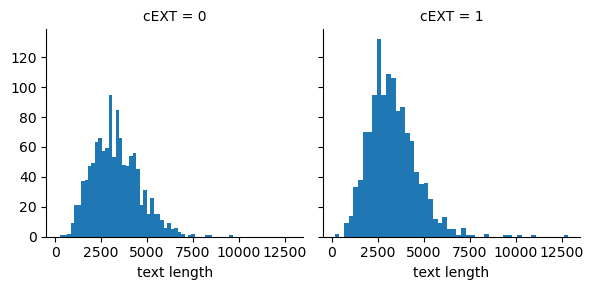

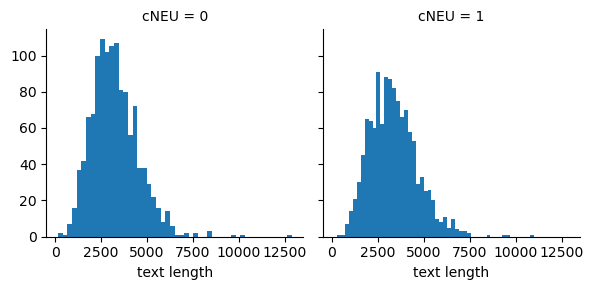

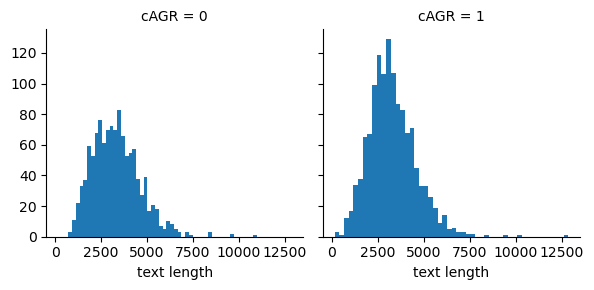

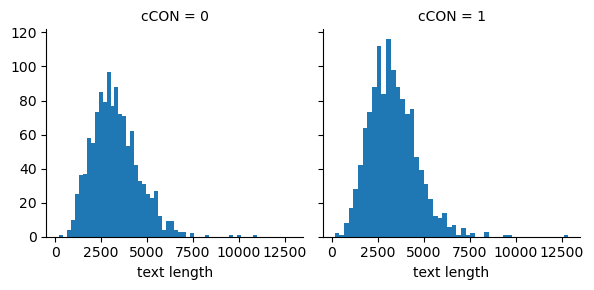

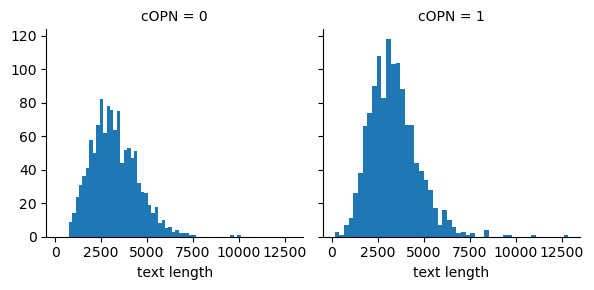

In [60]:
viz = visualize(data_essays, X_essays, labels)
viz.textlength_vs_labels_histogram()

##### Boxplots of text length distrbution for the different labels

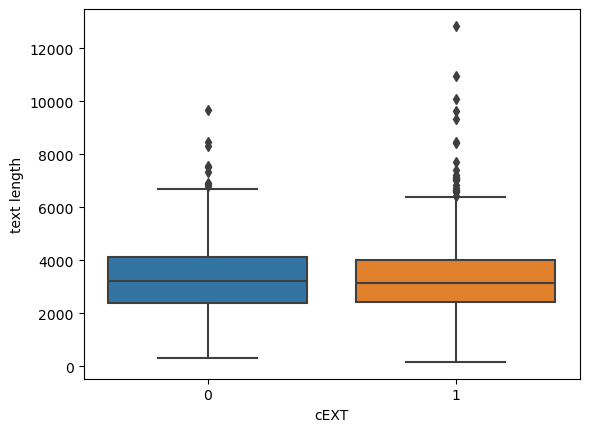

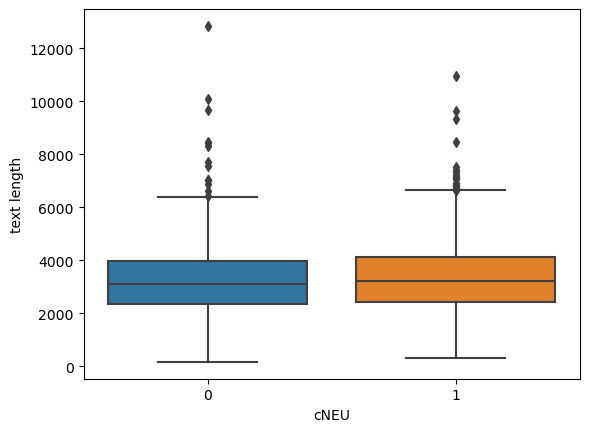

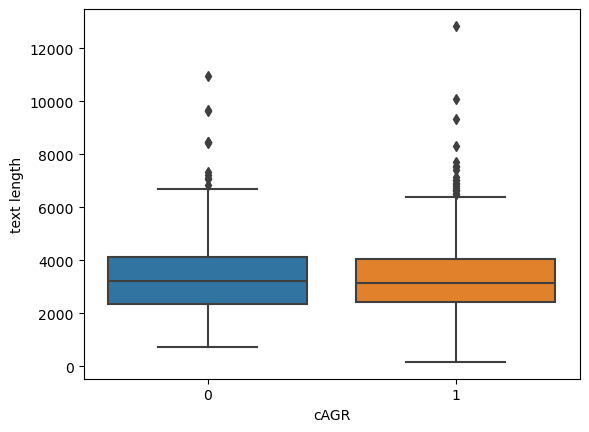

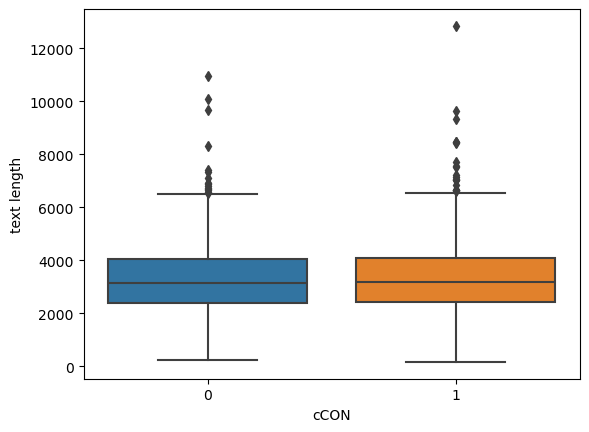

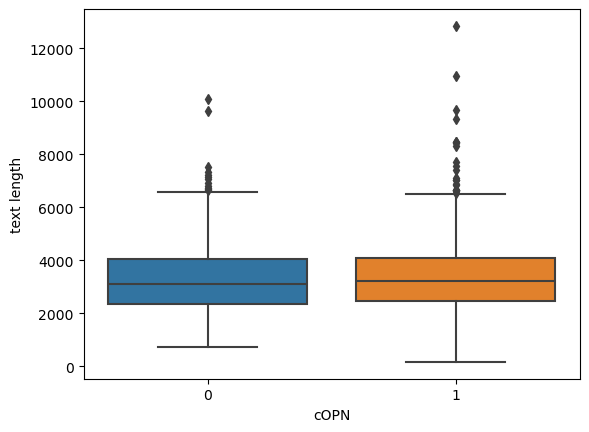

In [56]:
viz.textlength_vs_labels_boxplot()

##### Most frequent words in the corpus

List of 100 most frequent words/counts
[('I', 115487), ('.', 111178), ('to', 56263), (',', 47355), ('the', 38232), ('and', 36810), ('that', 29456), ('a', 28412), ('my', 26580), ('is', 25576), ('of', 22939), ('it', 22782), ("n't", 19996), ('in', 17828), ('do', 17448), ('have', 16166), ('me', 14588), ('so', 13099), ('but', 13060), ('this', 12054), ('be', 11724), ('for', 11520), ("'s", 11198), ('was', 10392), ('am', 10378), ('like', 10308), ('just', 10250), ('really', 10207), ('not', 10015), ("'m", 9973), ('on', 9015), ('about', 8941), ('with', 8708), ('think', 8061), ('are', 7602), ('what', 7517), ('all', 7475), ('at', 7469), ('because', 7144), ('i', 7048), ('know', 6959), ('get', 6875), ('he', 6605), ('now', 6154), ('would', 6077), ('you', 6013), ('if', 6001), ('time', 5966), ('out', 5923), ('they', 5905), ('up', 5743), ('or', 5733), ('going', 5621), ('go', 5576), ('she', 5556), ('?', 5539), ('want', 5483), ('will', 5420), ('can', 5276), ('!', 4959), ('as', 4939), ('people', 4898), ('he

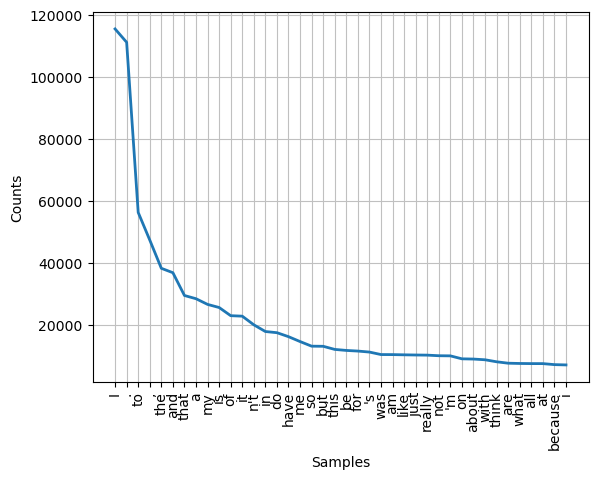

In [57]:
viz.most_frequent_words()

##### Statistics on the text corpus

In [62]:
viz.get_corpus_statistics()

The total number of texts is 2467
The total number of words in all texts is 1608813
The average number of words in each text is 652.1333603567085


### Train models

In [87]:
import re
import numpy as np
import string
import pickle
from nltk.corpus import stopwords as sw
from nltk.tokenize import sent_tokenize, wordpunct_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from sklearn.base import BaseEstimator, TransformerMixin
from keras.preprocessing.sequence import pad_sequences

class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, corpus, max_sentence_len=300, stopwords=None, punct=None, lower=True, strip=True):
        """
        Initializes the preprocessor with options for tokenization and lemmatization.
        """
        self.lower = lower
        self.strip = strip
        self.stopwords = set(stopwords) if stopwords else set(sw.words('english'))
        self.punct = set(punct) if punct else set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()
        self.corpus = corpus
        self.max_sentence_len = max_sentence_len

    def fit(self, X, y=None):
        """
        Fit method does nothing, returns self.
        """
        return self

    def transform(self, X):
        """
        Preprocess the text by cleaning, tokenizing, and lemmatizing.
        Returns the vectorized and padded sequences.
        """
        output = np.array([self.tokenize(doc) for doc in X])
        return output

    def tokenize(self, document):
        """
        Tokenizes and lemmatizes the input document.
        """
        lemmatized_tokens = []

        # Text cleaning using regex
        document = self.clean_text(document)

        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Tokenize and POS tag
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                token = self.preprocess_token(token)
                if token and token not in self.stopwords:
                    lemma = self.lemmatize(token, tag)
                    lemmatized_tokens.append(lemma)

        # Convert the token list into a single string
        doc = ' '.join(lemmatized_tokens)

        # Vectorize and pad the sequence
        tokenized_document = self.vectorize([doc])
        return tokenized_document

    def clean_text(self, text):
        """
        Cleans the input text using regular expressions.
        """
        text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
        return text

    def preprocess_token(self, token):
        """
        Applies lowercasing and stripping to tokens.
        """
        if self.lower:
            token = token.lower()
        if self.strip:
            token = token.strip('_').strip('*').strip()
        return token if token not in self.punct else None

    def lemmatize(self, token, tag):
        """
        Lemmatizes the token using the POS tag.
        """
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)
        return self.lemmatizer.lemmatize(token, tag)

    def vectorize(self, doc):
        """
        Converts text to a sequence of integers and pads the sequence.
        """
        # Load pre-trained tokenizer
        save_path = "/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/padding.pickle"
        with open(save_path, 'rb') as f:
            tokenizer = pickle.load(f)

        # Vectorize and pad
        doc_pad = tokenizer.texts_to_sequences(doc)
        doc_pad = pad_sequences(doc_pad, padding='pre', truncating='pre', maxlen=self.max_sentence_len)
        return np.squeeze(doc_pad)


#### Train Keras model

In [105]:
class train:

    def __init__(self, corpus):
        self.max_sentence_len = 300
        self.max_features = 300
        self.embed_dim = 300
        self.lstm_out = 180
        self.dropout_lstm = 0.3
        self.recurrent_dropout_lstm = 0.3
        self.dropout = 0.3
        self.conv_nfilters = 128
        self.conv_kernel_size = 8
        self.max_pool_size = 2
        self.NLTKPreprocessor = self.NLTKPreprocessor(corpus)
        #self.MyRNNTransformer = self.MyRNNTransformer()


    class NLTKPreprocessor(BaseEstimator, TransformerMixin):
        """
        Transforms input data by using NLTK tokenization, POS tagging, lemmatization and vectorization.
        """

        def __init__(self, corpus, max_sentence_len = 300, stopwords=None, punct=None, lower=True, strip=True):
            """
            Instantiates the preprocessor.
            """
            self.lower = lower
            self.strip = strip
            self.stopwords = set(stopwords) if stopwords else set(sw.words('english'))
            self.punct = set(punct) if punct else set(string.punctuation)
            self.lemmatizer = WordNetLemmatizer()
            self.corpus = corpus
            self.max_sentence_len = max_sentence_len

        def fit(self, X, y=None):
            """
            Fit simply returns self.
            """
            return self

        def inverse_transform(self, X):
            """
            No inverse transformation.
            """
            return X

        def transform(self, X):
            """
            Actually runs the preprocessing on each document.
            """
            output = np.array([(self.tokenize(doc)) for doc in X])
            return output

        def tokenize(self, document):
            """
            Returns a normalized, lemmatized list of tokens from a document by
            applying segmentation, tokenization, and part of speech tagging.
            Uses the part of speech tags to look up the lemma in WordNet, and returns the lowercase
            version of all the words, removing stopwords and punctuation.
            """
            lemmatized_tokens = []

            # Clean the text
            document = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", document)
            document = re.sub(r"what's", "what is ", document)
            document = re.sub(r"\'s", " ", document)
            document = re.sub(r"\'ve", " have ", document)
            document = re.sub(r"can't", "cannot ", document)
            document = re.sub(r"n't", " not ", document)
            document = re.sub(r"i'm", "i am ", document)
            document = re.sub(r"\'re", " are ", document)
            document = re.sub(r"\'d", " would ", document)
            document = re.sub(r"\'ll", " will ", document)
            document = re.sub(r"(\d+)(k)", r"\g<1>000", document)

            # Break the document into sentences
            for sent in sent_tokenize(document):

                # Break the sentence into part of speech tagged tokens
                for token, tag in pos_tag(wordpunct_tokenize(sent)):

                    # Apply preprocessing to the token
                    token = token.lower() if self.lower else token
                    token = token.strip() if self.strip else token
                    token = token.strip('_') if self.strip else token
                    token = token.strip('*') if self.strip else token

                    # If punctuation or stopword, ignore token and continue
                    if token in self.stopwords or all(char in self.punct for char in token):
                        continue

                    # Lemmatize the token
                    lemma = self.lemmatize(token, tag)
                    lemmatized_tokens.append(lemma)

            doc = ' '.join(lemmatized_tokens)
            tokenized_document = self.vectorize(np.array(doc)[np.newaxis])
            return tokenized_document


        def vectorize(self, doc):
            """
            Returns a vectorized padded version of sequences.
            """
            save_path = "/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/padding.pickle"
            with open(save_path, 'rb') as f:
                tokenizer = pickle.load(f)
            doc_pad = tokenizer.texts_to_sequences(doc)
            doc_pad = pad_sequences(doc_pad, padding='pre', truncating='pre', maxlen=self.max_sentence_len)
            return np.squeeze(doc_pad)

        def lemmatize(self, token, tag):
            """
            Converts the Penn Treebank tag to a WordNet POS tag, then uses that
            tag to perform WordNet lemmatization.
            """
            tag = {
                'N': wn.NOUN,
                'V': wn.VERB,
                'R': wn.ADV,
                'J': wn.ADJ
            }.get(tag[0], wn.NOUN)

            return self.lemmatizer.lemmatize(token, tag)


    class MyRNNTransformer(BaseEstimator, TransformerMixin):
        """
        Transformer allowing our Keras model to be included in our pipeline
        """
        def __init__(self, classifier):
            self.classifier = classifier

        def fit(self, X, y):
            batch_size = 32
            num_epochs = 135
            batch_size = batch_size
            epochs = num_epochs
            self.classifier.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2)
            return self

        def transform(self, X):
            self.pred = self.classifier.predict(X)
            self.classes = [[0 if el < 0.2 else 1 for el in item] for item in self.pred]
            return self.classes


    def multiclass_accuracy(self,predictions, target):
        "Returns the multiclass accuracy of the classifier's predictions"
        score = []
        for j in range(0, 5):
            count = 0
            for i in range(len(predictions)):
                if predictions[i][j] == target[i][j]:
                    count += 1
            score.append(count / len(predictions))
        return score


    def load_google_vec(self):

        return KeyedVectors.load_word2vec_format(
            '/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/GoogleNews-vectors-negative300.bin',
            binary=True)

    def lemmatize_token(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)
        return WordNetLemmatizer().lemmatize(token, tag)


    def get_preprocessed_corpus(self, X_corpus):
        """
        Returns a preprocessed version of a full corpus (ie. tokenization and lemmatization using POS taggs)
        """
        X = ' '.join(X_corpus)
        lemmatized_tokens = []

        # Break the document into sentences
        for sent in sent_tokenize(X):

            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):

                # Apply preprocessing to the token
                token = token.lower()
                token = token.strip()
                token = token.strip('_')
                token = token.strip('*')

                # If punctuation or stopword, ignore token and continue
                if token in set(sw.words('english')) or all(char in set(string.punctuation) for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize_token(token, tag)
                lemmatized_tokens.append(lemma)

        doc = ' '.join(lemmatized_tokens)
        return doc


    def prepare_embedding(self, X):
        """
        Returns the embedding weights matrix, the word index, and the word-vector dictionnary corresponding
        to the training corpus set of words.
        """
        # Load Word2Vec vectors
        word2vec = self.load_google_vec()

        # Fit and apply an NLTK tokenizer on the preprocessed training corpus to obtain sequences.
        tokenizer = Tokenizer(num_words=self.max_features)
        X_pad = self.get_preprocessed_corpus(X)
        tokenizer.fit_on_texts(pd.Series(X_pad))
        X_pad = tokenizer.texts_to_sequences(pd.Series(X_pad))

        # Pad the sequences
        X_pad = pad_sequences(X_pad, maxlen=self.max_sentence_len, padding='post', truncating='post')

        # Retrieve the word index
        train_word_index = tokenizer.word_index

        # Construct the embedding weights matrix and word-vector dictionnary
        train_embedding_weights = np.zeros((len(train_word_index) + 1, self.embed_dim))
        for word, index in train_word_index.items():
            train_embedding_weights[index, :] = word2vec[word] if word in word2vec else np.random.rand(self.embed_dim)
        word_vector_dict = dict(zip(pd.Series(list(train_word_index.keys())),
                                    pd.Series(list(train_word_index.keys())).apply(
                                        lambda x: train_embedding_weights[train_word_index[x]])))
        return train_embedding_weights, train_word_index, word_vector_dict


    def run(self, X, y, model_name=None, pretrained_weights_path = None, pretrained_model_path = None, verbose=True):
        """
        Builds a classifer for the given list of documents and targets

        """

        def build(classifier, X, y, embedding_dict, corpus):
            """
            Inner build function that builds a pipeline including a preprocessor and a classifier.
            """
            model = Pipeline([
                ('preprocessor', self.NLTKPreprocessor),
                ('classifier', classifier)
            ])
            return model.fit(X, y)

        # Label encode the targets
        y_trans = y

        # Prepare the embedding
        train_embedding_weights, train_word_index, wv_dict = self.prepare_embedding(X)

        # Begin evaluation
        if verbose: print("Building for evaluation")
        indices = range(len(y))

        # Keras model definition
        Input_words = Input(shape=(300,), name='input1')
        x = Embedding(len(train_word_index) + 1, self.embed_dim, weights=[train_embedding_weights],
                      input_length=self.max_sentence_len, trainable=True)(Input_words)
        
        # classifier.add(Embedding(30000, 300,input_length = 350))
        x = Conv1D(filters=self.conv_nfilters, kernel_size= self.conv_kernel_size, padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=self.max_pool_size)(x)
        x = SpatialDropout1D(self.dropout)(x)
        x = BatchNormalization()(x)

        x = Conv1D(filters=(self.conv_nfilters)*2, kernel_size= self.conv_kernel_size, padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=self.max_pool_size)(x)
        x = SpatialDropout1D(self.dropout)(x)
        x = BatchNormalization()(x)

        x = Conv1D(filters=(self.conv_nfilters)*3, kernel_size= self.conv_kernel_size, padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=self.max_pool_size)(x)
        x = SpatialDropout1D(self.dropout)(x)
        x = BatchNormalization()(x)

        x = LSTM(self.lstm_out, return_sequences=True, dropout=self.dropout_lstm, recurrent_dropout=self.recurrent_dropout_lstm)(x)
        x = LSTM(self.lstm_out, return_sequences=True, dropout=self.dropout_lstm, recurrent_dropout=self.recurrent_dropout_lstm)(x)
        x = LSTM(self.lstm_out, dropout=self.dropout_lstm, recurrent_dropout=self.recurrent_dropout_lstm)(x)
        x = Dense(128, activation='softmax')(x)
        out = Dense(5, activation='softmax')(x)

        classifier = Model(inputs=Input_words, outputs=[out])
        classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(classifier.summary())

        # Loading pretrained model for transfer learning
        if pretrained_weights_path and pretrained_model_path:
            json_file = open(pretrained_model_path, 'r')
            classifier = model_from_json(json_file.read())
            classifier.load_weights(pretrained_weights_path)
            classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            json_file.close()
            model = build(self.MyRNNTransformer(classifier), X, y_trans, wv_dict, corpus=X)
            
        # Train on the whole set from scratch
        if verbose: 
            print("Building complete model and saving ...")
            model= build(self.MyRNNTransformer(classifier), X, y_trans, wv_dict, corpus=X)

        # Save the model
        if model_name:
            outpath = '/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Models/'
            classifier.save_weights(outpath + model_name + '.weights.h5')
            with open(outpath + model_name + '.json', 'w') as json_file:
                json_file.write(classifier.to_json())
            print("Model written out to {}".format(model_name))
        else:
            print('Please provide model name for saving')
        
        return model

In [106]:
import warnings
warnings.filterwarnings("ignore")

In [107]:
model = train(X_train).run(X_train, y_train, "Personality_traits_NN")

Building for evaluation


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input1 (InputLayer)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 300, 300)       │     6,733,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 300, 128)       │       307,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_15            │ (None, 150, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 150, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 150, 256)       │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_16            │ (None, 75, 256)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 75, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 75, 384)        │       786,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 37, 384)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_17            │ (None, 37, 384)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 37, 384)        │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 37, 180)        │       406,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 37, 180)        │       259,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 180)            │       259,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        23,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,043,269 (34.50 MB)

 Trainable params: 9,041,733 (34.49 MB)

 Non-trainable params: 1,536 (6.00 KB)

None
Building complete model and saving ...
Epoch 1/135
62/62 - 9s - 144ms/step - accuracy: 0.1029 - loss: 4.1392
Epoch 2/135
62/62 - 5s - 79ms/step - accuracy: 0.1181 - loss: 4.1389
Epoch 3/135
62/62 - 5s - 76ms/step - accuracy: 0.1181 - loss: 4.1390
Epoch 4/135
62/62 - 5s - 77ms/step - accuracy: 0.1181 - loss: 4.1389
Epoch 5/135
62/62 - 5s - 79ms/step - accuracy: 0.1181 - loss: 4.1390
Epoch 6/135
62/62 - 5s - 80ms/step - accuracy: 0.1181 - loss: 4.1389
Epoch 7/135
62/62 - 5s - 83ms/step - accuracy: 0.1181 - loss: 4.1389
Epoch 8/135
62/62 - 5s - 80ms/step - accuracy: 0.1181 - loss: 4.1390
Epoch 9/135
62/62 - 5s - 87ms/step - accuracy: 0.1181 - loss: 4.1390
Epoch 10/135
62/62 - 5s - 84ms/step - accuracy: 0.1181 - loss: 4.1389
Epoch 11/135
62/62 - 5s - 83ms/step - accuracy: 0.1181 - loss: 4.1389
Epoch 12/135
62/62 - 5s - 85ms/step - accuracy: 0.1181 - loss: 4.1389
Epoch 13/135
62/62 - 5s - 83ms/step - accuracy: 0.1181 - loss: 4.1390
Epoch 14/135
62/62 - 5s - 88ms/step - accuracy: 0.1181

### Test models

#### Test Keras model

In [116]:
class test:

    def __init__(self):
        self.max_sentence_len = 300
        self.max_features = 300
        self.embed_dim = 300
        self.NLTKPreprocessor = self.NLTKPreprocessor()
        #self.MyRNNTransformer = self.MyRNNTransformer()


    class NLTKPreprocessor(BaseEstimator, TransformerMixin):
        """
        Transforms input data by using NLTK tokenization, POS tagging, lemmatization and vectorization.
        """

        def __init__(self, max_sentence_len = 300, stopwords=None, punct=None, lower=True, strip=True):
            """
            Instantiates the preprocessor.
            """
            self.lower = lower
            self.strip = strip
            self.stopwords = set(stopwords) if stopwords else set(sw.words('english'))
            self.punct = set(punct) if punct else set(string.punctuation)
            self.lemmatizer = WordNetLemmatizer()
            self.max_sentence_len = max_sentence_len

        def fit(self, X, y=None):
            """
            Fit simply returns self.
            """
            return self

        def inverse_transform(self, X):
            """
            No inverse transformation.
            """
            return X

        def transform(self, X):
            """
            Actually runs the preprocessing on each document.
            """
            output = np.array([(self.tokenize(doc)) for doc in X])
            return output

        def tokenize(self, document):
            """
            Returns a normalized, lemmatized list of tokens from a document by
            applying segmentation, tokenization, and part of speech tagging.
            Uses the part of speech tags to look up the lemma in WordNet, and returns the lowercase
            version of all the words, removing stopwords and punctuation.
            """
            lemmatized_tokens = []

            # Clean the text
            document = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", document)
            document = re.sub(r"what's", "what is ", document)
            document = re.sub(r"\'s", " ", document)
            document = re.sub(r"\'ve", " have ", document)
            document = re.sub(r"can't", "cannot ", document)
            document = re.sub(r"n't", " not ", document)
            document = re.sub(r"i'm", "i am ", document)
            document = re.sub(r"\'re", " are ", document)
            document = re.sub(r"\'d", " would ", document)
            document = re.sub(r"\'ll", " will ", document)
            document = re.sub(r"(\d+)(k)", r"\g<1>000", document)

            # Break the document into sentences
            for sent in sent_tokenize(document):

                # Break the sentence into part of speech tagged tokens
                for token, tag in pos_tag(wordpunct_tokenize(sent)):

                    # Apply preprocessing to the token
                    token = token.lower() if self.lower else token
                    token = token.strip() if self.strip else token
                    token = token.strip('_') if self.strip else token
                    token = token.strip('*') if self.strip else token

                    # If punctuation or stopword, ignore token and continue
                    if token in self.stopwords or all(char in self.punct for char in token):
                        continue

                    # Lemmatize the token
                    lemma = self.lemmatize(token, tag)
                    lemmatized_tokens.append(lemma)

            doc = ' '.join(lemmatized_tokens)
            tokenized_document = self.vectorize(np.array(doc)[np.newaxis])
            return tokenized_document


        def vectorize(self, doc):
            """
            Returns a vectorized padded version of sequences.
            """
            save_path = "/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Data/padding.pickle"
            with open(save_path, 'rb') as f:
                tokenizer = pickle.load(f)
            doc_pad = tokenizer.texts_to_sequences(doc)
            doc_pad = pad_sequences(doc_pad, padding='pre', truncating='pre', maxlen=self.max_sentence_len)
            return np.squeeze(doc_pad)

        def lemmatize(self, token, tag):
            """
            Converts the Penn Treebank tag to a WordNet POS tag, then uses that
            tag to perform WordNet lemmatization.
            """
            tag = {
                'N': wn.NOUN,
                'V': wn.VERB,
                'R': wn.ADV,
                'J': wn.ADJ
            }.get(tag[0], wn.NOUN)

            return self.lemmatizer.lemmatize(token, tag)


    class MyRNNTransformer(BaseEstimator, TransformerMixin):
        """
        Transformer allowing our Keras model to be included in our pipeline
        """
        def __init__(self, classifier):
            self.classifier = classifier

        def fit(self, X, y):
            batch_size = 32
            num_epochs = 35
            batch_size = batch_size
            epochs = num_epochs
            self.classifier.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2)
            return self

        def transform(self, X):
            self.pred = self.classifier.predict(X)
            self.classes = [[0 if el < 0.2 else 1 for el in item] for item in self.pred]
            return self.pred

    def multiclass_accuracy(self,predictions, target):
        "Returns the multiclass accuracy of the classifier's predictions"
        score = []
        for j in range(0, 5):
            count = 0
            for i in range(len(predictions)):
                if predictions[i][j] == target[i][j]:
                    count += 1
            score.append(count / len(predictions))
        return score


    def run(self, X, y, model_name):
        """
        Returns the predictions from the pipeline including our NLTKPreprocessor and Keras classifier.
        """
        def build(classifier):
            """
            Inner build function that builds a pipeline including a preprocessor and a classifier.
            """
            model = Pipeline([
                    ('preprocessor', self.NLTKPreprocessor),
                    ('classifier', classifier)
                ])
            return model

        save_path = '/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Text/Models/'
        json_file = open(save_path + model_name + '.json', 'r')
        
        classifier = model_from_json(json_file.read())

        classifier.load_weights(save_path + model_name + '.weights.h5')
        classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        json_file.close()
        model = build(self.MyRNNTransformer(classifier))
        y_pred = model.transform(X)
        y_pred_classes = [[0 if el < 0.2 else 1 for el in item] for item in y_pred]
        print(self.multiclass_accuracy(y.values.tolist(), y_pred_classes))

        return y_pred

In [117]:
len(X_test)

494

In [119]:
import warnings
warnings.filterwarnings("ignore")

In [120]:
pred = test().run(X_test, y_test, model_name = "Personality_traits_NN")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
[0.5101214574898786, 0.48785425101214575, 0.5303643724696356, 0.4979757085020243, 0.48582995951417]
